<a href="https://colab.research.google.com/github/Shinde-nutan/Skin-Cancer-type-detection-deeplearning/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
import pandas as pd

In [ ]:
od.download("https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000")

100%|██████████| 5.20G/5.20G [00:23<00:00, 240MB/s]


In [ ]:
df = pd.read_csv("/content/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [ ]:
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

In [ ]:
lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']
lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

# Maping the lesion type and ID to a dict.
df['lesion_type']=df['dx'].map(lesion_type_dict)
df['lesion_ID'] = df['dx'].map(lesion_ID_dict)

# Display the total found images.
print('Total number of images', len(df))


Total number of images 10015


In [ ]:
df['lesion_type'].value_counts()


Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_type, dtype: int64

In [ ]:
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


In [ ]:
fname_images = np.array(df['image_id'])
file_to_read ='/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'+str(fname_images[12])+'.jpg'

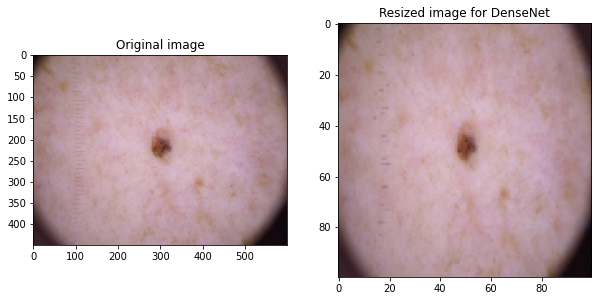

In [ ]:
img = cv2.imread(file_to_read)
img2 = cv2.resize(img, (100, 100))

# Show one exampe image before and after
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, ::-1])
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(img2[:, :, ::-1])
plt.title('Resized image for DenseNet')
plt.show()

In [ ]:
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, \
     Dense, Input, Activation, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from cv2 import imread, resize # manipulating the images
from tensorflow.keras.optimizers import Adam
import os

In [ ]:
def produce_new_img(img2: cv2) -> tuple:
    imga = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2, cv2.ROTATE_180)
    imgd = cv2.flip(img2, 0)
    imge = cv2.flip(img2, 1)
    new_imges = imga, imgb, imgc, imgd ,imge
    return new_imges

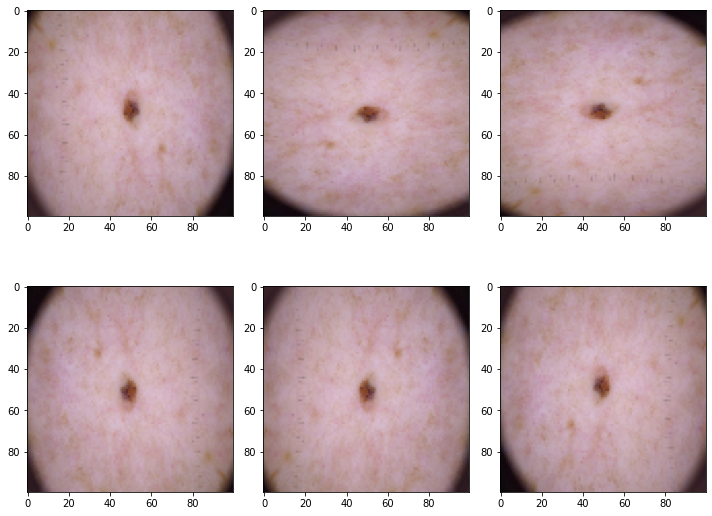

In [ ]:
def show_example():
    plt.figure(figsize = (10, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(img2[:, :, ::-1])
    for i in range(5):
        plt.subplot(2, 3, 2+i)
        plt.imshow(new_img[i][:, :, ::-1])
    plt.tight_layout()
    plt.show()
new_img = produce_new_img(img2)

show_example()

In [ ]:
x = []
y = []

lista1 = os.listdir('/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/')
lista2 = os.listdir('/content/skin-cancer-mnist-ham10000/HAM10000_images_part_2/')

for i in range(len(lista1)):
    
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/' + str(fname_image) 
    img = imread(file_to_read)                                  
    img2 = resize(img,(100, 100))                               
    x.append(img2)
    output = np.array(df[df['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])
    if i % 100 == 0:
        print(i, 'images loaded')
for i in range(len(lista2)):

    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/content/skin-cancer-mnist-ham10000/HAM10000_images_part_2/' + str(fname_image)


    img = imread(file_to_read)
    img2 = resize(img, (100, 100))
    x.append(img2)
   
    output = np.array(df[df['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
   
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])
    
    if i % 100 == 0:
        print(len(lista1) + i,'images loaded')

0 images loaded
200 images loaded
300 images loaded
500 images loaded
900 images loaded
1000 images loaded
1100 images loaded
1200 images loaded
1300 images loaded
1600 images loaded
1700 images loaded
1800 images loaded
2000 images loaded
2100 images loaded
2200 images loaded
2300 images loaded
2600 images loaded
2900 images loaded
3000 images loaded
3200 images loaded
3700 images loaded
3800 images loaded
3900 images loaded
4200 images loaded
4300 images loaded
4400 images loaded
4600 images loaded
4700 images loaded
4800 images loaded
4900 images loaded
5000 images loaded
5300 images loaded
5500 images loaded
5600 images loaded
5700 images loaded
5800 images loaded
5900 images loaded
6000 images loaded
6100 images loaded
6200 images loaded
6300 images loaded
6400 images loaded
6600 images loaded
6700 images loaded
6800 images loaded
6900 images loaded
7100 images loaded
7300 images loaded
7400 images loaded
7500 images loaded
7600 images loaded
7700 images loaded
7800 images loaded


In [ ]:
x = np.array(x)
y = np.array(y)

y_train = to_categorical(y, num_classes = 7)

X_train, X_test, y_train, y_test = train_test_split(x,                  
                                                    y_train,            
                                                    test_size = 0.20,   
                                                    random_state = 50,  
                                                    stratify = y)       

print('Train dataset shape', X_train.shape)
print('Test dataset shape', X_test.shape)

Train dataset shape (21252, 100, 100, 3)
Test dataset shape (5313, 100, 100, 3)


In [ ]:
def est_class_weights(dis_id: np.array) -> dict:
    
    class_weights = np.around(compute_class_weight(class_weight = 'balanced', classes = np.unique(dis_id), y = y), 2)
    class_weights = dict(zip(np.unique(dis_id), class_weights))

y_id = np.array(df['lesion_ID'])
new_class_weights = est_class_weights(y_id)
print(new_class_weights)


None


In [ ]:
#CNN model
model = Sequential()
        

model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="valid"))
model.add(BatchNormalization())


model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(BatchNormalization())


model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten()) 

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))

model.add(Dense(7, activation = 'softmax'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
def mod_checkpoint_callback() -> None:
    
    trained_model = ModelCheckpoint(filepath = 'model.h5',  
                             save_weights_only = False,     
                             monitor = 'val_accuracy',      
                             mode = 'auto',                 
                             save_best_only = True,     
                             verbose = 1)
    return trained_model


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
early_stopping_monitor = EarlyStopping(patience = 35, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()


optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

datagen = ImageDataGenerator(zoom_range = 0.3, horizontal_flip = True, shear_range = 0.3)
datagen.fit(X_train)

batch_size = 32
epochs = 35


history = model.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )


Epoch 1/35
665/665 [==============================] - ETA: 0s - loss: 1.2524 - accuracy: 0.5175
Epoch 1: val_accuracy improved from -inf to 0.31131, saving model to model.h5
665/665 [==============================] - 63s 79ms/step - loss: 1.2524 - accuracy: 0.5175 - val_loss: 2.0172 - val_accuracy: 0.3113
Epoch 2/35
665/665 [==============================] - ETA: 0s - loss: 1.0539 - accuracy: 0.5892
Epoch 2: val_accuracy improved from 0.31131 to 0.40448, saving model to model.h5
665/665 [==============================] - 52s 79ms/step - loss: 1.0539 - accuracy: 0.5892 - val_loss: 1.4863 - val_accuracy: 0.4045
Epoch 3/35
665/665 [==============================] - ETA: 0s - loss: 0.9915 - accuracy: 0.6154
Epoch 3: val_accuracy improved from 0.40448 to 0.47751, saving model to model.h5
665/665 [==============================] - 51s 77ms/step - loss: 0.9915 - accuracy: 0.6154 - val_loss: 1.4227 - val_accuracy: 0.4775
Epoch 4/35
665/665 [==============================] - ETA: 0s - loss: 0.9

In [26]:
scores = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 1s 6ms/step - loss: 0.5023 - accuracy: 0.8238
Accuracy: 82.38%
